In [1]:
import os 
import numpy as np
import h5py as h5
import nrrd
import fnmatch
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'

from skimage.measure import label
from skimage.morphology import remove_small_objects
from skimage.segmentation import relabel_sequential

In [2]:
def readH5(file_path,**kwargs):
    """
    generic function to read a h5 file with one 
    subgroup elements by given filepath in a Dictonary 
    """

    import h5py as h5
    
    out = {}

    with h5.File(file_path, 'r') as f:

        for key in f.keys():

            if isinstance(f[key],h5.Group):
                out[key] = {}
                for sub_key in f[key]:
                    out[key][sub_key] = f[key][sub_key][...]
            else:
                out[key] = f[key][:]
        f.close()
    return out

In [3]:
file_path   = "/Volumes/projects/pore-detection/Parallelprobe_Grauwerte/Parallelprobe_Grauwerte.seg.vol.train.pred.h5"
assert os.path.exists(file_path)

In [4]:
file   = readH5(file_path)
for key, item in file.items():
    if isinstance(item, dict):
        print(key)
        for subkey, subitems in item.items():
            print(subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

predictions (763, 211, 886) uint8


In [5]:
key = "labels"

obj_ids = np.unique(file[key])
print(obj_ids)
print(len(obj_ids))

obj_ids = obj_ids[0:]
file["masks"] = file[key] == obj_ids[:, None, None, None]

for key, item in file.items():
    if isinstance(item, dict):
        print(key,":")
        for subkey, subitems in item.items():
            print("\t",subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

file["predictions"] = 1 - file[key] ## channel mismatch 0 is pore and 1 is background wtf

KeyError: 'labels'

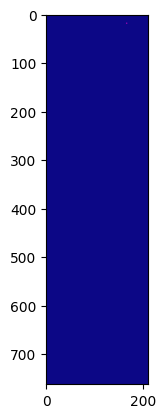

In [6]:
plt.imshow(1-file["predictions"][:,:,0])

In [5]:
key = "predictions"
labeled_image = label(1-file[key][:],connectivity=2)

print(len(np.unique(labeled_image)))

cleaned_labeled_image = remove_small_objects(labeled_image, min_size=3)

print(len(np.unique(cleaned_labeled_image)))

file["instances"] = cleaned_labeled_image

# cleaned_labeled_image_relabeled, _ , _ = relabel_sequential(cleaned_labeled_image)

# print(cleaned_labeled_image_relabeled.max())

# file["instances"] = cleaned_labeled_image_relabeled

print(len(np.unique(file["instances"])))

10225
8176
8176


In [6]:
print(file["instances"].max())

10224


[   0   92  137  209  290  321  378  389  395  504  564  761  764  936
 1037 1119 1170 1256 1494 1898 2714 2856 3021 3599 3828 3860 4057 4140
 4172 4212 4224 4237 4352 4363 4427 4466 4511 4557 4572 4622 4646 4689
 5109 5368 5481 5532 6429 6432 6765 6939 7098 7220 7387 7496 7733 7777
 7927 8010 8067]


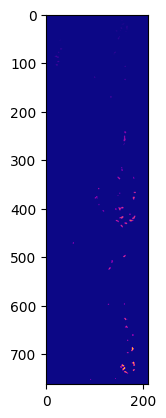

In [28]:

plt.imshow(file["instances"][:,:,10])
print(np.unique(file["instances"][:,:,10]))

In [7]:
for key, item in file.items():
    if isinstance(item, dict):
        print(key)
        for subkey, subitems in item.items():
            print(subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)

predictions (763, 211, 886) uint8
instances (763, 211, 886) int64


In [8]:
plt.imshow(file["labels"][50,::])
print(np.unique(file["labels"]))
# file["predictions"]=file["predictions"]
print(np.unique(file["labels"]))

KeyError: 'labels'

In [9]:
import matplotlib


def create_slicer_segmentation_header(size, spacing, space_origin, labels=None):
    """
    Create a NRRD header compatible with 3D Slicer for segmentations.
    """

    # Create a plasma colormap using the modern interface
    plasma_cmap = matplotlib.colormaps['plasma']  # Use matplotlib.colormaps
    # Base header
    header = {
        'type': 'int',
        'dimension': len(size),
        'space dimension': len(size),
        'sizes': size,
        'space': 'left-posterior-superior',
        'space origin': space_origin,
        'endian': 'little',
        'encoding': 'gzip',  # Optional compression
        'space directions': [[s if i == j else 0 for j in range(len(size))] for i, s in enumerate(spacing)],
        'kinds': ['domain'] * len(size),
    }

    # Add metadata for each segment
    if labels is not None:
        if not isinstance(labels, dict):
            raise ValueError("Labels must be a dictionary with integer keys and string values.")
        
        for segment_index, (label_value, segment_name) in enumerate(labels.items(), start=0):
            rgba = plasma_cmap(segment_index / len(labels))  # Normalize index
            rgb = [round(rgba[0], 4), round(rgba[1], 4), round(rgba[2], 4)] 

            header[f'Segment{segment_index}_ID'] = f"Segement_{segment_index}"  # Example color
            header[f'Segment{segment_index}_LabelValue'] = label_value
            header[f'Segment{segment_index}_Layer'] = 0
            header[f'Segment{segment_index}_Name'] = segment_name
            header[f'Segment{segment_index}_NameAutoGenerated'] = 0
            # header[f'Segment{segment_index}_Color'] = rgb  # Example color
            # header[f'Segment{segment_index}_ColorAutoGenerated'] = 0

            header[f'Segment{segment_index}_Tags'] = ''  # Optional tags


    header['Segmentation_ContainedRepresentationNames'] = 'Binary labelmap|'
    header['Segmentation_ReferenceImageExtentOffset'] = [0, 0, 0]
    header['Segmentation_MasterRepresentation'] = 'Binary labelmap'


    return header

In [10]:
def numpy_dtype_to_nrrd_dtype(dtype):
    """
    Convert NumPy dtype to NRRD dtype string.

    Parameters:
    - dtype: NumPy dtype object

    Returns:
    - NRRD dtype string
    """
    dtype_mapping = {
        np.uint8: 'uint8',
        np.uint16: 'uint16',
        np.uint32: 'uint32',
        np.uint64: 'uint64',
        np.int8: 'int8',
        np.int16: 'int16',
        np.int32: 'int32',
        np.int64: 'int64',
        np.float16: 'float16',
        np.float32: 'float32',
        np.float64: 'float64',
    }

    return dtype_mapping.get(dtype, 'unknown')

In [11]:
out_key_list = ["predictions"]
batch_size = 100

for key in out_key_list:

    # Determine file ending based on key
    if key == "raw":
        fileending = ".vol.nrrd"
    elif key == "labels":
        fileending = ".gtruth.instances.nrrd"
    elif key == "predictions":
        fileending = ".pred.instances.nrrd"

    instances = file["instances"]
    total_instances = instances.max()
    print(total_instances)
    print(len(np.unique(file["instances"])))
    batches = range(1, total_instances + 1, batch_size)

    for i, start_label in enumerate(batches):
        end_label = min(start_label + batch_size - 1, total_instances)

        fileout = os.path.basename(file_path).split('.')[0] + f"_{i:02d}" + fileending
        print(f"Processing batch {i}: {fileout}")

        # Create labels
        
        labels = {instance: f'pore_{instance:03d}' for instance in range(start_label, end_label + 1)}

        # Create a batch mask
        batch_mask = np.where((instances >= start_label) & (instances <= end_label), 
                              instances, 
                              0).astype(np.int32)

        # Metadata
        size = batch_mask.shape
        spacing = (1, 1, 1)
        space_origin = (0, 0, 0)

        # Generate header
        header = create_slicer_segmentation_header(size, spacing, space_origin, labels)

        # Save to NRRD
        nrrd.write(fileout, batch_mask, header=header)
        print(f"Saved: {fileout}")

        # Break after one batch for testing
        # if i >= 1:
        #     break

10224
8176
Processing batch 0: Parallelprobe_Grauwerte_00.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_00.pred.instances.nrrd
Processing batch 1: Parallelprobe_Grauwerte_01.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_01.pred.instances.nrrd
Processing batch 2: Parallelprobe_Grauwerte_02.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_02.pred.instances.nrrd
Processing batch 3: Parallelprobe_Grauwerte_03.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_03.pred.instances.nrrd
Processing batch 4: Parallelprobe_Grauwerte_04.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_04.pred.instances.nrrd
Processing batch 5: Parallelprobe_Grauwerte_05.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_05.pred.instances.nrrd
Processing batch 6: Parallelprobe_Grauwerte_06.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_06.pred.instances.nrrd
Processing batch 7: Parallelprobe_Grauwerte_07.pred.instances.nrrd
Saved: Parallelprobe_Grauwerte_07.pred.instances.nrrd
Processing batch 8: P

In [ ]:
# Load the NRRD file

data, header = nrrd.read('Pinprobe_komplett_00.pred.instances.nrrd')

# Print the header
print("Header:")
for key, value in header.items():
    print(f"{key}: {value}")

# Access the data if needed
print("\nData Shape:", data.shape)

In [ ]:
n = len(data.keys())
fig, axs = plt.subplots(1,n,figsize=(n*3.5,3.5))

axs = np.array(axs).flatten()
for ax in axs: ax.axis("off")

slice = 30

# axs[0].imshow(data["raw"][:,:,slice],cmap="grey")
axs[0].imshow(data["labels"][:,:,slice])

In [ ]:
obj_ids = np.unique(data["labels"])

print(len(obj_ids))

obj_ids = obj_ids[0:]
data["masks"] = data["labels"] == obj_ids[:, None, None, None]

for key, item in data.items():
    if isinstance(item, dict):
        print(key,":")
        for subkey, subitems in item.items():
            print("\t",subkey,subitems.shape,subitems.dtype,subitems)
    else:
        print(key,item.shape,item.dtype)


In [ ]:
labels = np.zeros((2,*data["labels"].shape))

for cls in range(1,data["masks"].shape[0]):
    labels[cls-1] = label(data["masks"][cls,::],connectivity=2)

    plt.imshow(labels[cls-1,:,:,slice])
    plt.show()

data["labels"] = labels.astype(np.int16)

print(data["labels"].dtype)


In [ ]:
labels = label(data["masks"][1,::],connectivity=2)

print(len(np.unique(labels)))

plt.imshow(labels[50,::],cmap="plasma")

In [ ]:
data_type_seg = data["raw"].dtype
size = data["raw"].shape

spacing = (1,1,1)
space_origin = (0 , 0 , 0 )

header = create_nrrd_header(size, spacing, space_origin, data_type_seg)

fileout = os.path.basename(file_path).split('.')[0]
print(fileout)

In [ ]:
nrrd.write(os.path.join(fileout + ".vol"+ ".nrrd"), data["raw"],header=header)
nrrd.write(os.path.join(fileout + ".label"+ ".nrrd"), data["labels"],header=header)
nrrd.write(os.path.join(fileout + ".labels"+ ".nrrd"), labels,header=header)


# for i,cls in enumerate(["weft","fill"]):  
#     nrrd.write(os.path.join(fileout + f".{cls}" +".pred"+ ".nrrd"), data["labels"][i,::],header=header_seg)

In [ ]:
found_first_item = False
for root, dirs, files in os.walk(src_path):

    for dir_name in dirs:
        # print(dir_name)
        if "rand_subvolume" in dir_name.lower():
            # print(dir_name)
            print(os.listdir(os.path.join(root,dir_name)))
            for file in fnmatch.filter(os.listdir(os.path.join(root,dir_name)),"*.h5"):
                
                print(os.path.join(root,dir_name,file))
                file_path = os.path.join(root,dir_name,file)

                data = readH5(file_path)

                data_type = data["raw"].dtype
                size = data["raw"].shape
                spacing = ( data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"],
                            data["volume_data"]["VoxelSizeX"]
                            )

                space_origin = data["volume_data"]["Origin"]*spacing
                print(data_type,len(size),spacing,space_origin)


                header = create_nrrd_header(size, spacing, space_origin, data_type)
                fileout = os.path.splitext(file)[0]


                nrrd.write(os.path.join(root,dir_name,fileout + ".nrrd"), data["raw"],header=header)
                


                found_first_item = False
                
        if found_first_item:
            break
    if found_first_item:
            break        